In [45]:

import image_reader as ir
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import random

def plot_pdf(intensities, domain):
	plt.figure(figsize=(8, 8))
	plt.plot(np.linspace(0, domain, len(intensities)), intensities, color='magenta', linewidth=2)
	plt.xlabel(r'$\theta$', fontsize=22)
	plt.ylabel('Energy p(X)', fontsize=22)
	plt.title('Probability Density Function (PDF) of Rows', fontsize=22, pad=25)
	plt.grid(True, color='white', alpha=.5)
	plt.gca().set_facecolor('black')
	plt.tick_params(axis='both', which='major', labelsize=14)
	plt.xlim(0, domain)
	plt.ylim(0, np.max(intensities))
	y_increment = np.max(intensities) / 10
	plt.yticks(np.arange(0, np.max(intensities) + y_increment, y_increment))
	plt.show()

def plot_cdf(cdf, domain):
	plt.figure(figsize=(8, 8))
	plt.plot(np.linspace(0, domain, len(cdf)), cdf, color='magenta', linewidth=2)
	plt.xlabel(r'$\theta$', fontsize=22)
	plt.ylabel('Energy p(X)', fontsize=22)
	plt.title('Cumulative Distribution Function (CDF) of Intensities', fontsize=22, pad=25)
	plt.grid(True, color='white', alpha=.5)
	plt.gca().set_facecolor('black')
	plt.tick_params(axis='both', which='major', labelsize=14)
	plt.xlim(0, domain)
	plt.ylim(0, 1)
	plt.yticks(np.arange(0, 1.1, 0.1))
	plt.show()



def gamma_correction(image, gamma=2.2):
	return np.power(image, 1 / gamma)

def clamp(image):
	return np.clip(image, 0, 1)

def pfm_to_ppm(image, scaling_factor=1):
    return (gamma_correction(image / scaling_factor, 2.2) * 255).astype(np.uint8)

In [2]:
grace_path = os.path.join("..", "GraceCathedral", "grace_latlong.pfm")
grace_pfm = ir.read_pfm(grace_path)
print(grace_pfm.shape)
pixel_extent = 5


(512, 1024, 3)


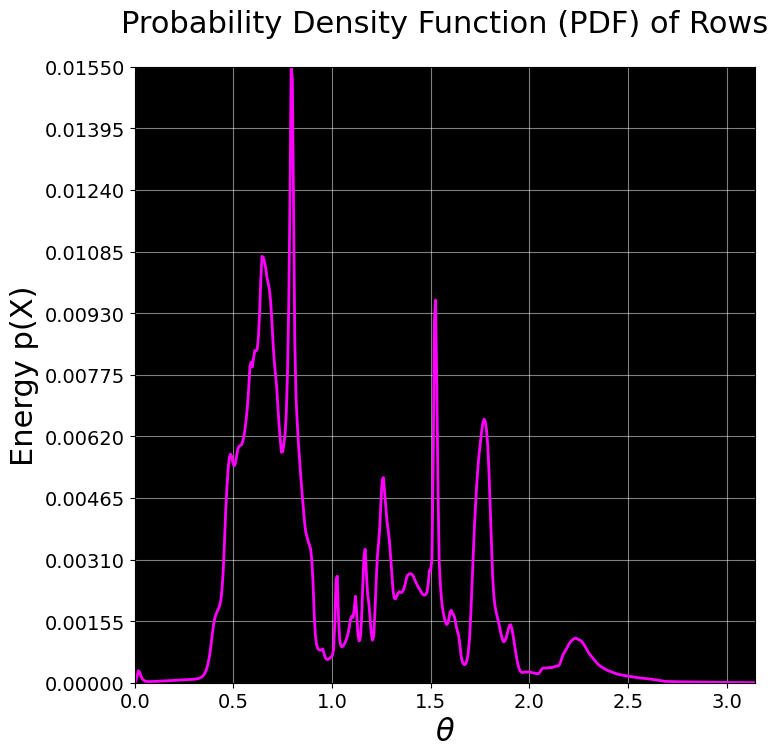

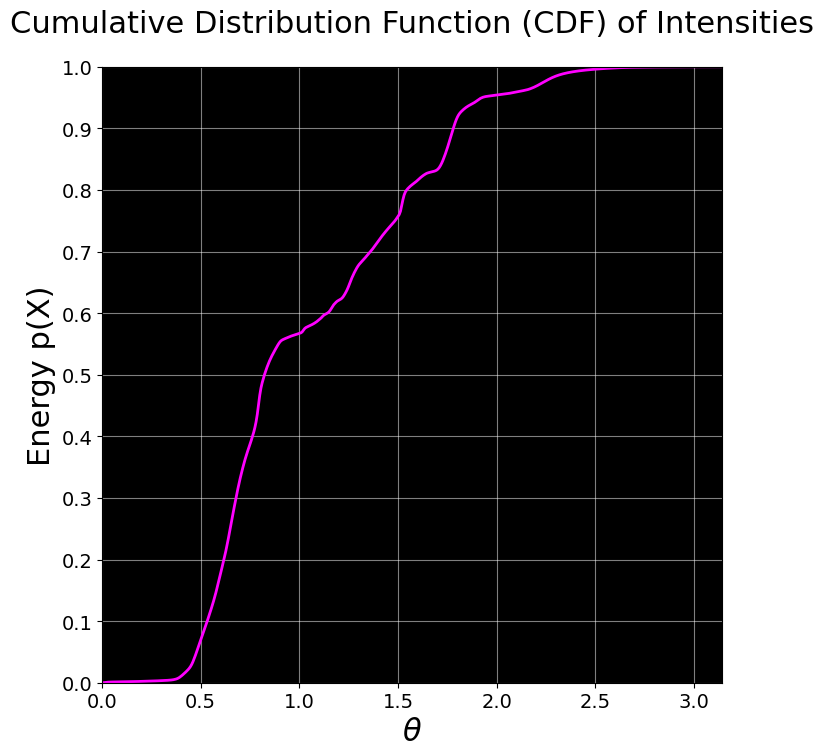

1.0


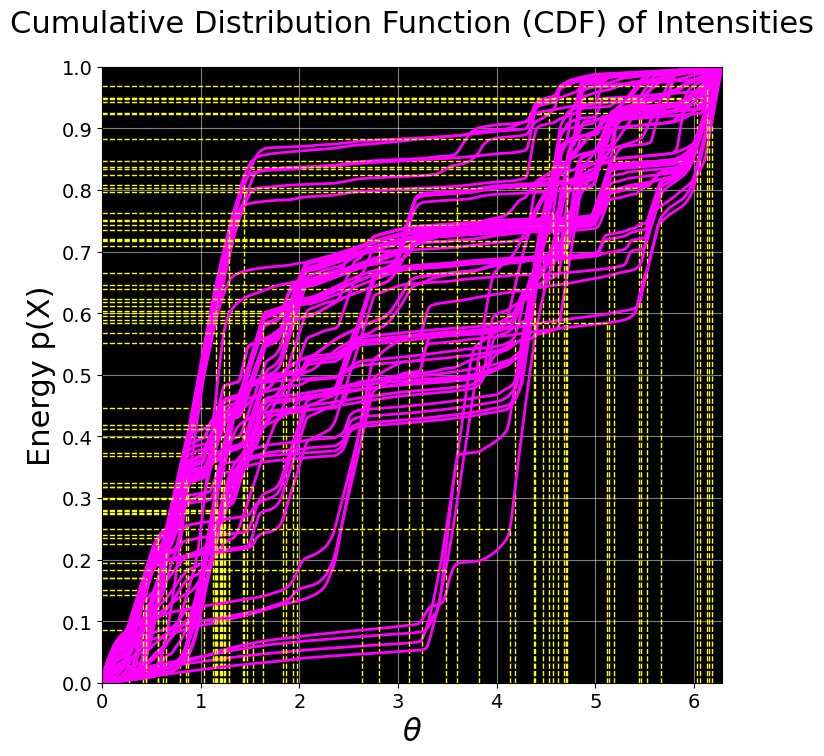

In [46]:
intensities = np.array([np.sum(grace_pfm[i]) * math.sin((math.pi) * i / grace_pfm.shape[0]) for i in range(grace_pfm.shape[0])])
intensities /= np.sum(intensities)
cdf = np.cumsum(intensities)
plot_pdf(intensities, math.pi)
plot_cdf(cdf, math.pi)

clamped_grace = clamp(grace_pfm)
scaling_factor = np.max(clamped_grace)
print(scaling_factor)


def plot_cdf_sample(cdf, domain, sample_index):
	plt.plot(np.linspace(0, domain, len(cdf)), cdf, color='magenta', linewidth=2)
	x_value = np.linspace(0, domain, len(cdf))[sample_index]
	y_value = cdf[sample_index]
	plt.plot([x_value, x_value], [0, y_value], color='yellow',  linestyle='--', linewidth=1)
	plt.plot([0, x_value], [y_value, y_value], color='yellow', linestyle='--', linewidth=1)

plt.figure(figsize=(8, 8))
plt.xlabel(r'$\theta$', fontsize=22)
plt.ylabel('Energy p(X)', fontsize=22)
plt.title('Cumulative Distribution Function (CDF) of Intensities', fontsize=22, pad=25)
plt.grid(True, color='white', alpha=.5)
plt.gca().set_facecolor('black')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(0, 2*math.pi)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))


for samples in [64]: #,256,1024]:
	grace_sampled = clamped_grace.copy()
	if samples == 256:
		grace_copy = np.zeros(clamped_grace.shape).astype(np.float32)

	for i in range(samples):

		randrow = np.searchsorted(cdf, random.uniform(0, 1))

		sampled_row = [sum(p) for p in clamped_grace[randrow]]
		sampled_row /= np.sum(sampled_row)
		row_cdf = np.cumsum(sampled_row)

		randcol = np.searchsorted(row_cdf, random.uniform(0, 1))

		# plot_pdf(sampled_row, 2*math.pi)
		# plot_cdf(row_cdf, 2*math.pi)

# 		plot_cdf_sample(row_cdf, 2*math.pi, randcol)

# plt.show()

		for i in range(pixel_extent):
			for j in range(pixel_extent):
				edge = pixel_extent // 2
				if randrow - edge + i >= 0 and randrow - edge + i < clamped_grace.shape[0] and randcol - edge + j >= 0 and randcol - edge + j < clamped_grace.shape[1]:
					grace_sampled[randrow - edge + i, randcol - edge + j] = [0, 0, 1]

					if samples == 256:
						grace_copy[randrow - edge + i, randcol - edge + j] = clamped_grace[randrow - edge + i, randcol - edge + j]
	
	
	# ir.write_pfm(gamma_correction(grace_sampled), f"output/grace_sampled_{samples}.pfm")
	# ir.write_ppm(pfm_to_ppm(grace_sampled, scaling_factor), f"output/grace_sampled_{samples}.ppm")
 
	# if samples == 256:
	# 	ir.write_pfm(gamma_correction(grace_copy), f"output/selected_samples.pfm")
	# 	ir.write_ppm(pfm_to_ppm(grace_copy, scaling_factor), f"output/selected_samples.ppm")


